In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
suds = ['re.session.login3.hrlee.018404.0020', 
        're.session.login3.hrlee.018404.0021',
        're.session.login3.hrlee.018404.0022']
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [3]:
ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [4]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [5]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login3.hrlee.018404.0020:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 220
	Number of requested GPUs: 240
	Number of requested nodes: 40.0
	Number of nodes asked by ENTK: 5
	Number of tasks executed by EnTK: 241
	Number of tasks successfully executed by EnTK: 0
	Number of failed tasks: 241


re.session.login3.hrlee.018404.0021:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 220
	Number of requested GPUs: 240
	Number of requested nodes: 40.0
	Number of nodes asked by ENTK: 5
	Number of tasks executed by EnTK: 241
	Number of tasks successfully executed by EnTK: 0
	Number of failed tasks: 241


re.session.login3.hrlee.018404.0022:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of

In [6]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           } ]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_w'] - ss[sid]['ttx_u']})

/Users/mturilli/Virtualenvs/rp-paper-frontera/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


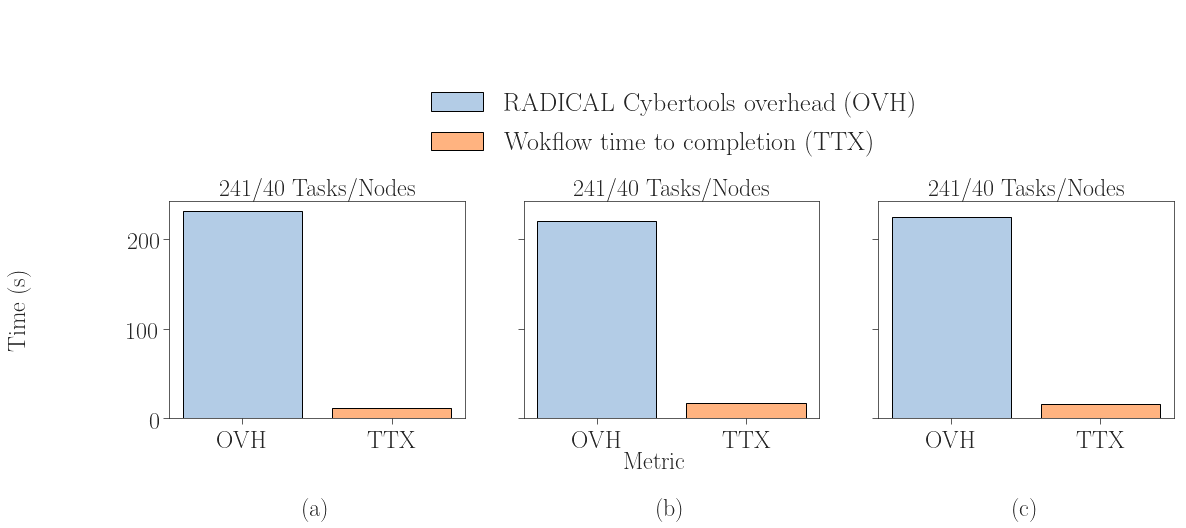

In [7]:
fwidth = 18
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    ax = axarr[i]
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text(0   ,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(0.5 , -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Wokflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.6), fontsize=26, ncol=1)

plt.savefig('figures/extasy_aggregated_overheads.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/extasy_aggregated_overheads.png', dpi=300, bbox_inches='tight')

In [8]:
from radical.pilot import states as rps

for sid in suds:
    u  = ss[sid]['u']

    ss[sid].update({
        'umgr_sched_queue'  : u.duration( event=[{ru.STATE: rps.NEW                        },
                                                 {ru.STATE: rps.UMGR_SCHEDULING            } ]), 
        'umgr_stage_input'  : u.duration( event=[{ru.STATE: rps.UMGR_STAGING_INPUT_PENDING },
                                                 {ru.STATE: rps.UMGR_STAGING_INPUT         } ]), 
        'agent_stage_input' : u.duration( event=[{ru.STATE: rps.AGENT_STAGING_INPUT_PENDING},
                                                 {ru.STATE: rps.AGENT_SCHEDULING_PENDING   } ]), 
        'agent_sched_queue' : u.duration( event=[{ru.STATE: rps.AGENT_SCHEDULING_PENDING   },
                                                 {ru.EVENT: 'schedule_ok'                  } ]), 
        'agent_exec_queue'  : u.duration( event=[{ru.EVENT: 'schedule_ok'                  },
                                                 {ru.STATE: rps.AGENT_EXECUTING            } ]),
        'agent_exec_prep'   : u.duration( event=[{ru.STATE: rps.AGENT_EXECUTING            },
                                                 {ru.EVENT: 'exec_start'                   } ]),
        'agent_exec_rp'     : u.duration( event=[{ru.EVENT: 'exec_start'                   },
                                                 {ru.EVENT: 'cu_start'                     } ]),
        'agent_exec_sh'     : u.duration( event=[{ru.EVENT: 'cu_start'                     },
                                                 {ru.EVENT: 'cu_exec_start'                } ]),
        'agent_exec_cmd'    : u.duration( event=[{ru.EVENT: 'cu_exec_start'                },
                                                 {ru.EVENT: 'cu_exec_stop'                 } ]),
        'agent_term_sh'     : u.duration( event=[{ru.EVENT: 'cu_exec_stop'                 },
                                                 {ru.EVENT: 'cu_stop'                      } ]),
        'agent_term_rp'     : u.duration( event=[{ru.EVENT: 'cu_stop'                      },
                                                 {ru.EVENT: 'exec_stop'                    } ]),
        'agent_unschedule'  : u.duration( event=[{ru.EVENT: 'exec_stop'                    },
                                                 {ru.EVENT: 'unschedule_stop'              } ]),
        'agent_stage_output': u.duration( event=[{ru.EVENT: 'unschedule_stop'              },
                                                 {ru.STATE: rps.UMGR_STAGING_OUTPUT        } ])
    })

In [9]:
for sid in suds:
    print("""
%s:
\tumgr_sched_queue  : %s
\tumgr_stage_input  : %s
\tagent_stage_input : %s
\tagent_sched_queue : %s
\tagent_exec_queue  : %s
\tagent_exec_prep   : %s
\tagent_exec_rp     : %s
\tagent_exec_sh     : %s
\tagent_exec_cmd    : %s
\tagent_term_sh     : %s
\tagent_term_rp     : %s
\tagent_unschedule  : %s
\tagent_stage_output: %s
""" % (sid                         , 
       ss[sid]['umgr_sched_queue'] ,
       ss[sid]['umgr_stage_input'] ,
       ss[sid]['agent_stage_input'],
       ss[sid]['agent_sched_queue'],
       ss[sid]['agent_exec_queue'] , 
       ss[sid]['agent_exec_prep']  , 
       ss[sid]['agent_exec_rp']    , 
       ss[sid]['agent_exec_sh']    , 
       ss[sid]['agent_exec_cmd']   , 
       ss[sid]['agent_term_sh']    , 
       ss[sid]['agent_term_rp']    , 
       ss[sid]['agent_unschedule'] ,
       ss[sid]['agent_stage_output']))


re.session.login3.hrlee.018404.0020:
	umgr_sched_queue  : 1.6778383255004883
	umgr_stage_input  : 0.11180663108825684
	agent_stage_input : 7.567907810211182
	agent_sched_queue : 18.41944146156311
	agent_exec_queue  : 5.289620399475098
	agent_exec_prep   : 5.931647777557373
	agent_exec_rp     : 0.04279732704162598
	agent_exec_sh     : 26.0
	agent_exec_cmd    : 12.0
	agent_term_sh     : 2.0
	agent_term_rp     : 6.91789436340332
	agent_unschedule  : 0.7078566551208496
	agent_stage_output: 36.11735939979553


re.session.login3.hrlee.018404.0021:
	umgr_sched_queue  : 1.399623155593872
	umgr_stage_input  : 0.12241458892822266
	agent_stage_input : 7.3734471797943115
	agent_sched_queue : 13.543877124786377
	agent_exec_queue  : 5.603925466537476
	agent_exec_prep   : 6.120118618011475
	agent_exec_rp     : 0.07611966133117676
	agent_exec_sh     : 27.0
	agent_exec_cmd    : 17.0
	agent_term_sh     : 1.0
	agent_term_rp     : 12.785014867782593
	agent_unschedule  : 2.245802402496338
	agent_stage_out

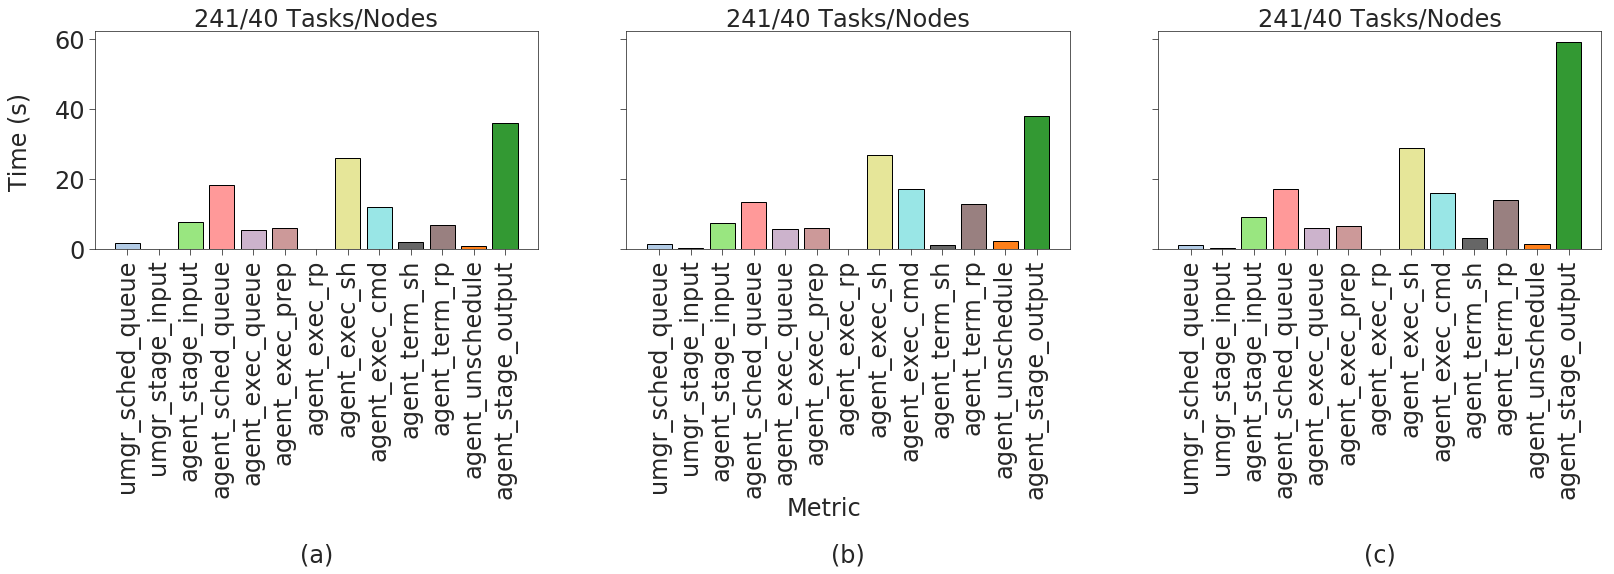

In [10]:
plt.rc('text', usetex=False)

fwidth = 27
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    ax = axarr[i]
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'umgr_sched_queue', height = ss[sid]['umgr_sched_queue'], color = tableau20[1])
    ax.bar(x = 'umgr_stage_input', height = ss[sid]['umgr_stage_input'], color = tableau20[3])
    ax.bar(x = 'agent_stage_input', height = ss[sid]['agent_stage_input'], color = tableau20[5])
    ax.bar(x = 'agent_sched_queue', height = ss[sid]['agent_sched_queue'], color = tableau20[7])
    ax.bar(x = 'agent_exec_queue', height = ss[sid]['agent_exec_queue'], color = tableau20[9])
    ax.bar(x = 'agent_exec_prep', height = ss[sid]['agent_exec_prep'], color = tableau20[11])
    ax.bar(x = 'agent_exec_rp', height = ss[sid]['agent_exec_rp'], color = tableau20[13])
    ax.bar(x = 'agent_exec_sh', height = ss[sid]['agent_exec_sh'], color = tableau20[15])
    ax.bar(x = 'agent_exec_cmd', height = ss[sid]['agent_exec_cmd'], color = tableau20[17])
    ax.bar(x = 'agent_term_sh', height = ss[sid]['agent_term_sh'], color = tableau20[19])
    ax.bar(x = 'agent_term_rp', height = ss[sid]['agent_term_rp'], color = tableau20[21])
    ax.bar(x = 'agent_unschedule', height = ss[sid]['agent_unschedule'], color = tableau20[2])
    ax.bar(x = 'agent_stage_output', height = ss[sid]['agent_stage_output'], color = tableau20[4])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.tick_params(axis='x', labelrotation=90)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text(0.08,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(0.5 , -0.8, 'Metric'  , ha='center', fontsize=24)
# fig.legend(['exec_queue', 'Wokflow time to completion (TTX)'], loc='upper center', 
#            bbox_to_anchor=(0.52, 1.6), fontsize=26, ncol=1)

plt.savefig('figures/extasy_detailed_overheads.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/extasy_detailed_overheads.png', dpi=300, bbox_inches='tight')

In [11]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [12]:
sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [13]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [14]:
def update_ticks(x, pos):
    return int(x/4)

In [ ]:
# core/gpu utilization over time (box plot)

fwidth = 36
fhight = 8
fig, axarr = plt.subplots(1, len(suds), sharex='col', figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in suds:

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.07,  0.5, 'Core ID' , va='center', rotation='vertical', fontsize=24)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=24)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.7), fontsize=26, ncol=4)

plt.savefig('figures/extasy_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/extasy_ru.png', dpi=300, bbox_inches='tight')